# Donor Data: A Kaggle Classic

Here's some work I did for an interview process.  The question wasn't really "can you do multivariate data"? But more along the lines of "what would you break out for a quick id of potential donor populations" and "what other data might you bring in"?

In [165]:
# imports

import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import preprocessing as prep
from faker import Faker

# Source Material

https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a
https://cooldata.files.wordpress.com/2018/01/cool-data-a-handbook-for-predictive-modeling.pdf

Original Set At:
https://www.kaggle.com/datasets/michaelpawlus/fundraising-data/code

In [37]:
def process_strdollars(val):
    val=float(val.replace('$','').replace(',',''))
    return val

In [43]:
def conditional_log(val):
    if val!=0:
        val=np.log(val)
    return val

In [50]:
def impute_gender(row):
    val=0
    
    if row['Prefix is Mr.']==1:
        val=1
    elif row['Prefix is Ms.']==1:
        val=2
    elif row['Prefix is Mrs.']==1:
        val=2
    
    return val

In [149]:
def rec_mar_status(val):
    retval=val
    
    if pd.isna(val)==True:
        retval='NA'
    elif val not in ('M','U','S'):
        retval='O'
    return retval

# Retrieving Data

I doctored it in postgres so that I could do some window function work on the log of lhc.
As noted in the https://cooldata.files.wordpress.com/2018/01/cool-data-a-handbook-for-predictive-modeling.pdf ...
taming the lhc outlers by taking the log is a good move.
But we can also then do a decile on that log, can call it "lhc level", which will be a lot easier for a stakeholder to digest.

I also grouped the honorifics (e.g. "is Mr.") columns into an "imputed gender" category on the hunch that this would gather more explanatory power and was the analytic point of those categories anyway.  After which I dropped the honorific columns.

In [229]:
# retrieving sql output...

df = pd.read_csv('/Users/ouonomos/Documents/cool_unv_data2.tsv', sep='\t')


# A Super Quick Intuition

## The Graduate Year Concept

If you were to look at the book noted above, you'd find that "year graduated" is in inverse correlation to the log of lhc, which makes sense ... you will have less money to donate if you haven't graduated, or haven't been earning as long as a graduate.  I turned "year graduated" into "years since grad" variable by subtracting it from 2022.

Now you see a positive relationship pictured below.  But it's suspicious ... a great bulk of the data points are very old.  We're going to have to be better informed about the meaning of this variable, and qualify it per some "still alive" or "years left to donate" principle.

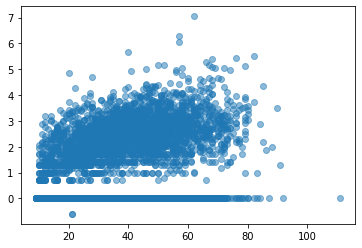

In [251]:
plt.scatter(df['years_since_grad'],df['log_lhc'], alpha=0.5)
plt.show()

Let's do some work with seaborn to cap the years after graduation to <=30 and eliminate 0 level donors.  Let's also Make the donor levels stand out:

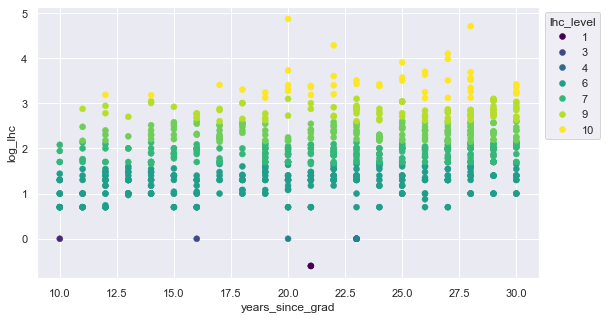

In [264]:
# n.b. :
# https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
# https://seaborn.pydata.org/generated/seaborn.move_legend.html
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels

df2=df.loc[(df['years_since_grad']<=30) & (df['lhc_clean']>0)]

sns.set(rc={'figure.figsize':(9,5)})
ax=sns.scatterplot(x='years_since_grad', y='log_lhc', data=df2, hue='lhc_level', ec=None, palette="viridis")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

This is quite suggestive.  Around 16 years we begin to get donors in the higher deciles.  Also, we can see that in every range of years after graduation there is potential to move donors from level to another.  Remember that they are coming into the set every year; it isn't a only static population aging from the left hand of the grid and getting wealthier.

## Continuing to Work Graduate Year Concept...

Now let's break it down to illustrate a common quick way to get at potential opportunities.

The idea is to breakout levels of giving (here, quartiles of log LHC) by other explanatory categories, and look for areas of overlap.  For example, there is overlap in years since grad between log_lhc_quart where the spouse_id is present, with respect to min-max range of years_since_grad. 

What we're aiming for is something like "These donors are in the same earning window (years since grad) and have the same marital status, but are at a lower giving tier.  Maybe we should approach them."  This is a basic routine you would extend for additionally fine grain, and for different combinations of variables, according to your intuition.

Note that the main finding is that we can increase giving by causing the lower tiers to get married.  Just kidding.

In [266]:
# n.b. df2 is the frame filtered on years_since_grad where donations are >0

table = pd.pivot_table(df2, values=['years_since_grad'], index=['log_lhc_qrt', 'spouseid_present'],
                       aggfunc={'years_since_grad': ["min", "max"]})
table

years_since_grad    
                                          max min
log_lhc_qrt spouseid_present                     
1           0                              23  10
2           0                              23  20
3           0                              30  10
            1                              30  10
4           0                              30  11
            1                              30  15

# On to Regression Review

The choice of spouseid_present in the table above was informed by a review of correlation and regression on log_lhc below.  Again, this is straight out of the accompanying book for the data set and is pretty much what I'd do for a start.  


# A Spot of Feature Engineering ...

Doing some onehot on marital the greatest frequencies of marital status after bucketing the small freq cats.



In [203]:
# recode for greatest frequency, keeping NaN
df['marital_status_rec']=df['marital_status'].apply(rec_mar_status)

df = pd.get_dummies(df, columns=['marital_status_rec'], dtype=int)
df.head()

,id_number,lifetimehc,email_present,busphone_present,grad_year,marital_status,spouseid_present,jobtitle_present,varsityath_present,studgovt_present,...,years_since_grad,imputed_gender,log_lhc,lhc_level,log_lhc_qrt,marital_status_rec_M,marital_status_rec_NA,marital_status_rec_O,marital_status_rec_S,marital_status_rec_U
0,1053807,$0.25,1,0,2001,S,0,0,0,0,...,21,1,-0.60206,1,1,0,0,0,1,0
1,1053757,$0.25,0,0,2001,U,0,0,0,0,...,21,1,-0.60206,1,1,0,0,0,0,1
2,1078367,$0.00,1,0,2003,M,0,1,0,0,...,19,1,0.00000,1,1,1,0,0,0,0
3,1023190,$0.00,1,0,1979,M,0,1,0,0,...,43,0,0.00000,1,1,1,0,0,0,0
4,1053899,$0.00,0,0,2001,NaN,0,0,0,0,...,21,2,0.00000,1,1,0,1,0,0,0


In [204]:
df.columns

Index(['id_number', 'lifetimehc', 'email_present', 'busphone_present',
       'grad_year', 'marital_status', 'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present', 'prefix_is_mr', 'prefix_is_ms', 'prefix_is_dr',
       'prefix_is_mrs', 'lhc_clean', 'years_since_grad', 'imputed_gender',
       'log_lhc', 'lhc_level', 'log_lhc_qrt', 'marital_status_rec_M',
       'marital_status_rec_NA', 'marital_status_rec_O', 'marital_status_rec_S',
       'marital_status_rec_U'],
      dtype='object')

# Reviewing Correlation ...

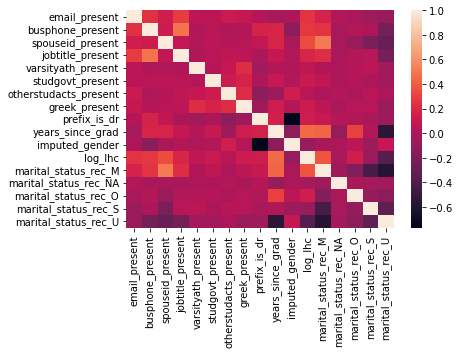

In [220]:


corr_eval_columns=['email_present', 'busphone_present',
       'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present','prefix_is_dr','years_since_grad','imputed_gender',
       'log_lhc','marital_status_rec_M',
       'marital_status_rec_NA', 'marital_status_rec_O', 'marital_status_rec_S',
       'marital_status_rec_U']
sns.heatmap(df[corr_eval_columns].corr());

In [206]:
df[corr_eval_columns].corr()[['log_lhc']].sort_values(by='log_lhc', ascending=False)

,log_lhc
log_lhc,1.000000
years_since_grad,0.441914
marital_status_rec_M,0.369081
spouseid_present,0.337671
busphone_present,0.262517
email_present,0.240848
jobtitle_present,0.181078
marital_status_rec_O,0.141047
prefix_is_dr,0.122937
greek_present,0.118937


# Basic Multivar Regression

Exactly like the book.  This is never a bad exploration. Interestingly, my one-hot on marital_status_rec_M gives me more correlation, but a little less r2, presumably because spouseid_present is more general.

In [217]:
x_explain=df[['years_since_grad','spouseid_present','busphone_present','email_present']]
x_explain = sm.add_constant(x_explain)
ks = sm.OLS(df['log_lhc'],x_explain)
ks_res =ks.fit()
print(ks_res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_lhc   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     614.4
Date:                Tue, 21 Nov 2023   Prob (F-statistic):               0.00
Time:                        09:44:08   Log-Likelihood:                -7594.4
No. Observations:                5000   AIC:                         1.520e+04
Df Residuals:                    4995   BIC:                         1.523e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4651      0.041  

# Other Directions

Having made a pass at the above set, what other data might I bring in?  There are two potential complementary directions that I'm sure are obvious to everyone:

1. Variables that focus the users demographically.  So for example user zipcodes, neighborhoods, etc.  The idea is to refine them so that you can group scalars like lifetime hc and disposable income and see how much of an outlier a user is relative to their group.  A high outlier + low donor level = better prospect.  
2. Scalars like putative disposable income.  This is gnarly to do yourself; you're likely to need a vendor. Again, these complement your demographic grouping categorical variables.